<a href="https://colab.research.google.com/github/AskFeeling/gme-data/blob/main/market_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from requests.auth import HTTPBasicAuth
import pandas as pd
from io import BytesIO
from google.colab import drive
 
# plotting
import matplotlib.pyplot as plt
import altair as alt

In [ ]:
drive.mount('/content/gdrive')
DRIVE_BASE = '/content/gdrive/My Drive'

In [ ]:
# Auth stuff

USER = 'nneibaue'
PW = 'J374qB3gFlpe'
URL_BASE = 'https://api.finra.org/{dtype}/group/{group}/name/{dataset}'

def get_metadata(group, dataset):
  url = URL_BASE.format(dtype='metadata', group=group, dataset=dataset)
  resp = requests.get(url, auth=HTTPBasicAuth(USER, PW))
  return resp.json()
  #return pd.read_csv(BytesIO(resp.content))

def get_data(group, dataset):
  url = URL_BASE.format(dtype='data', group=group, dataset=dataset)
  resp = requests.get(url, auth=HTTPBasicAuth(USER, PW))
  return pd.read_csv(BytesIO(resp.content))

In [ ]:
requests.get('https://api.finra.org/index', auth=HTTPBasicAuth(USER, PW))

<Response [403]>

In [ ]:
#test_url = 'https://api.finra.org/data/group/OTCMarket/name/weeklysummary?limit=10&fields=issueSymbolIdentifier,issueName,weekStartDate,totalWeeklyShareQuantity'
test_url = 'https://api.finra.org/data/group/OTCMarket/name/weeklysummary'
test_resp = api_call(test_url)
test_resp

NameError: ignored

In [ ]:
#group = 'OTCMarket'
group='NYSE'
dataset = 'equityShortInterest'

meta = get_metadata(group, dataset)
data = get_data(group, dataset)
data

NameError: ignored

In [ ]:
data[data['issueSymbolIdentifier'] == 'GME']

NameError: ignored

In [ ]:
#URL_BASE = 'http://regsho.finra.org/regsho-{month}.html'
CNMS_BASE = 'http://regsho.finra.org/CNMSshvol{date_string}.txt'



def find_data(years=['2020']):
  date_base = '{year}{month}{day}'
  dfs = []
  months = ['01', '02', '03', '04', '05', '06', '07',
            '08', '09', '10', '11', '12']
  for year in years:
    for month in months:
      for day in range(1, 32):
        if day < 10:
          ds = f'0{day}' 
        else:
          ds = f'{day}'
    
        url = CNMS_BASE.format(
            date_string=date_base.format(
                year=year,
                month=month,
                day=ds
            )
        )
        resp = requests.get(url)
        if resp.status_code == 200:
          #print(f'Data added for {year}/{month}/{day}')
          this_df = pd.read_csv(BytesIO(resp.content), delimiter='|')
          dfs.append(this_df)
      print(f'finished searching {year}/{month}')
  return pd.concat(dfs)

data = find_data(years=['2020', '2021'])

finished searching 2020/01
finished searching 2020/02
finished searching 2020/03
finished searching 2020/04
finished searching 2020/05
finished searching 2020/06
finished searching 2020/07
finished searching 2020/08
finished searching 2020/09
finished searching 2020/10
finished searching 2020/11
finished searching 2020/12
finished searching 2021/01
finished searching 2021/02
finished searching 2021/03
finished searching 2021/04
finished searching 2021/05
finished searching 2021/06
finished searching 2021/07
finished searching 2021/08
finished searching 2021/09
finished searching 2021/10
finished searching 2021/11
finished searching 2021/12


In [ ]:
# Process and join

# remove trash data with bad dates
data = data.loc[data.Date >= 10200000, :]

# get yahoo data
gme_yahoo = pd.read_csv(os.path.join(DRIVE_BASE, 'software_development', 'market_data', 'GME_yahoo_historical.csv'))

#convert dates
gme_yahoo['Date'] = pd.to_datetime(gme_yahoo.Date, format='%Y-%m-%d')
data['Date'] = pd.to_datetime(data.Date, format='%Y%m%d')

# Join 
gme_full = data[data.Symbol == 'GME'].join(gme_yahoo.set_index('Date'), on='Date')
gme_full.head()

NameError: ignored

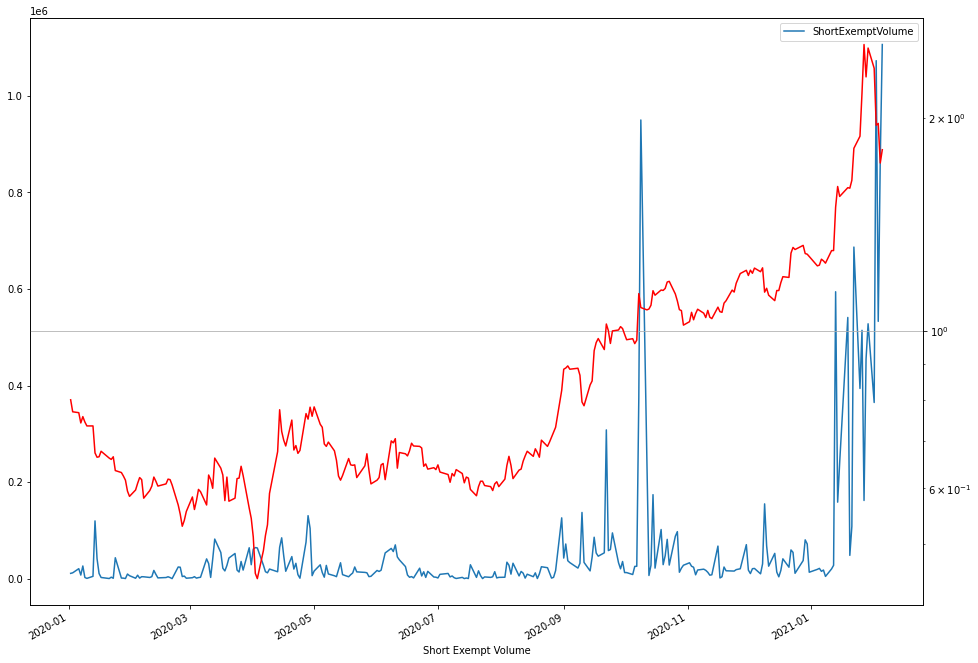

In [ ]:
import numpy as np
gme_full.plot(x='Date', y='ShortExemptVolume', figsize=(16, 12))
ax = plt.gca()
ax_price = ax.twinx()
ax_price.plot(gme_full['Date'], np.log10(gme_full['Close']), color='red')
ax_price.set_xlabel('Log (price)')
ax_price.set_yscale('log')
ax.set_xlabel('Short Exempt Volume')
ax_price.grid()

In [ ]:
gme_full.head()

,Date,Symbol,ShortVolume,ShortExemptVolume,TotalVolume,Market,Open,High,Low,Close,Adj Close,Volume
3119,2020-01-02,GME,1156897.0,10920.0,1724835.0,"B,Q,N",6.14,6.47,6.07,6.31,6.31,4453600
3115,2020-01-03,GME,832325.0,12001.0,1346908.0,"B,Q,N",6.21,6.25,5.84,5.88,5.88,3543900
3089,2020-01-06,GME,701807.0,20584.0,1199606.0,"B,Q,N",5.80,5.91,5.60,5.85,5.85,3394800
3073,2020-01-07,GME,962592.0,7363.0,2443567.0,"B,Q,N",5.77,5.83,5.44,5.52,5.52,5228000
3072,2020-01-08,GME,1279359.0,26196.0,2338618.0,"B,Q,N",5.49,5.85,5.41,5.72,5.72,5629400


In [ ]:
gme_full['TotalShortVolume'] = (gme_full['ShortExemptVolume'] + gme_full['ShortVolume'])
gme_full['ShortExemptPercent'] = gme_full['ShortExemptVolume'] / gme_full['TotalShortVolume']
gme_full['TotalShortPercent'] = gme_full['TotalShortVolume'] / gme_full['TotalVolume']
gme_full['PercentReportVolume'] = gme_full['TotalVolume'] / gme_full['Volume']
gme_full['DailyPercentChange'] = (100 * (gme_full['Close'] - gme_full['Open']) / gme_full['Open']).round(1)
gme_full.head()

,Date,Symbol,ShortVolume,ShortExemptVolume,TotalVolume,Market,Open,High,Low,Close,Adj Close,Volume,TotalShortVolume,ShortExemptPercent,TotalShortPercent,PercentReportVolume,DailyPercentChange
3119,2020-01-02,GME,1156897.0,10920.0,1724835.0,"B,Q,N",6.14,6.47,6.07,6.31,6.31,4453600,1167817.0,0.009351,0.677060,0.387290,2.8
3115,2020-01-03,GME,832325.0,12001.0,1346908.0,"B,Q,N",6.21,6.25,5.84,5.88,5.88,3543900,844326.0,0.014214,0.626862,0.380064,-5.3
3089,2020-01-06,GME,701807.0,20584.0,1199606.0,"B,Q,N",5.80,5.91,5.60,5.85,5.85,3394800,722391.0,0.028494,0.602190,0.353366,0.9
3073,2020-01-07,GME,962592.0,7363.0,2443567.0,"B,Q,N",5.77,5.83,5.44,5.52,5.52,5228000,969955.0,0.007591,0.396942,0.467400,-4.3
3072,2020-01-08,GME,1279359.0,26196.0,2338618.0,"B,Q,N",5.49,5.85,5.41,5.72,5.72,5629400,1305555.0,0.020065,0.558259,0.415429,4.2


In [ ]:
TOOLTIP_COLUMNS = ['DailyPercentChange', 'ShortVolume', 'ShortExemptVolume', 'TotalVolume', 'Volume']

open_close_color = alt.condition("datum.Open <= datum.Close",
                                 alt.value("#06982d"),
                                 alt.value("#ae1325"))

date_select = alt.selection_interval(fields=['Date'], encodings=['x'])


bar_base = alt.Chart(gme_full).mark_rect().encode(
    x=alt.X('Date:O'),
    tooltip=TOOLTIP_COLUMNS
)

short_volume_bar = bar_base.encode(
    y='TotalShortVolume',
    color='ShortExemptPercent',
)

total_volume_bar = bar_base.encode(
    y='TotalVolume',
    #color=alt.value('orange')
    color=alt.Color('TotalShortPercent',
                    scale=alt.Scale(scheme='yelloworangered')
    )
)

yahoo_volume_bar = bar_base.encode(
    y='Volume',
    color=alt.value('lightblue')
).interactive()

percent_report = alt.Chart(gme_full).mark_point().encode(
    x='Date:O',
    y='PercentReportVolume:Q'
)

base = alt.Chart(gme_full).encode(
    x='Date:O',
    color=open_close_color
)

rule = base.mark_rule(color='black').encode(
    alt.Y(
        'Low:Q',
        title='Price',
        scale=alt.Scale(type='log', base=10),
    ),
    alt.Y2('High:Q')
)

candle = base.mark_bar().encode(
    alt.Y('Open:Q'),
    alt.Y2('Close:Q')
)

candlestick_chart = (rule + candle)

#final = (total_volume_bar + short_volume_bar + candlestick_chart).resolve_scale(y='independent')

final = candlestick_chart & (
    ((yahoo_volume_bar) + total_volume_bar + short_volume_bar).resolve_scale(color='independent')) & \
    (percent_report)

final

alt.VConcatChart(...)

In [ ]:
# SAVE HTML

OUTPUT = os.path.join(DRIVE_BASE, 'software_development', 'market_data')

final.save(os.path.join(OUTPUT, 'final_dashboard.html'))